# SNV Binary Classifier

## Setup
To execute the following code, other than having dowmloaded the datasets from the repository, you need to have installed the following packages:

```sh
pip install tqdm keras_tqdm keras tensorflow
```

In [1]:
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback as ktqdm
from matplotlib import pyplot as plt
import math
import json
import numpy as np
import pandas as pd
import random
import os
import sys

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Reproducibility
The following is to allow for full reproducibility of results:

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Loading the dataset
We proceed to load the datasets from `TRAINING_DATASET_PATH` and `TESTING_DATASET_PATH`:

In [3]:
TRAINING_DATASET_PATH = "Mendelian.train.tsv"
TESTING_DATASET_PATH = "Mendelian.test.tsv"

In [4]:
def load_dataset(path):
    """Return the dataset at given path after having removed the metrics deemed useless (motivation in documentation)."""
    return pd.read_csv(
        path, sep='\t').drop(
            columns=["CpGobsExp", "CpGperCpG", "dbVARCount", "mamPhyloP46way"])

In [5]:
training = load_dataset(TRAINING_DATASET_PATH)

In [6]:
testing = load_dataset(TESTING_DATASET_PATH)

## Normalizing the dataset

We defined a common normalizer for training and testing based on the training dataset:

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(training)

We normalize the datasets:

In [8]:
normalized_training = scaler.transform(training)
normalized_testing =  scaler.transform(testing)

## Creating the labels
Now we proceeed to create the datasets labels:

The first `TRAINING_POSITIVES_NUMBER`, `TESTING_POSITIVES_NUMBER` data points represent the positives cases in the training and testing dataset respectively.

In [9]:
TRAINING_POSITIVES_NUMBER = 356
TESTING_POSITIVES_NUMBER = 40

Creating the training labels:

In [10]:
training_labels = np.zeros((len(normalized_training)))
training_labels[:TRAINING_POSITIVES_NUMBER] = np.ones((TRAINING_POSITIVES_NUMBER))

Creating the testing labels:

In [11]:
testing_labels = np.zeros((len(normalized_testing)))
testing_labels[:TESTING_POSITIVES_NUMBER] = np.ones((TESTING_POSITIVES_NUMBER))

## Creating the model

In [12]:
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import regularizers


def build_model():
    """Return the keras network model."""
    model = Sequential()
    # The input layer has 22 neurons and selu activation
    model.add(Dense(22, input_dim=22, name="Input_dense_layer"))
    model.add(Activation("selu", name="Input_SeLU"))
    # The hidden layer has 22 neurons and selu activation
    model.add(Dense(22, name="Hidden_dense_layer"))
    model.add(Activation("selu", name="Hidden_SeLU"))
    # The output layer has 1 neuron and sigmoid activation
    model.add(Dense(1, name="Output_dense_layer"))
    model.add(Activation("sigmoid", name="Sigmoid"))

    model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Network metrics

In [13]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve


def plot_model_roc(training_labels, training_prediction, testing_labels,
                   testing_prediction):
    """Plot roc graph from given labels and predictions."""
    plt.plot(
        *roc_curve(training_labels, training_prediction)[:2],
        label='Training ROC curve (area = %0.6f)' % roc_auc_score(training_labels, training_prediction))
    plt.plot(
        *roc_curve(testing_labels, testing_prediction)[:2],
        label='Testing ROC curve (area = %0.6f)' % roc_auc_score(testing_labels, testing_prediction))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)', fontsize=15)
    plt.legend(loc="lower right")

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_model_prc(training_labels, training_prediction, testing_labels,
             testing_prediction):
    """Plot Precision-Recall curve."""
    
    plt.plot(
        *precision_recall_curve(training_labels, training_prediction)[:2],
        label='Training average precision = %0.6f' % average_precision_score(
            training_labels, training_prediction))

    plt.plot(
        *precision_recall_curve(testing_labels, testing_prediction)[:2],
        label='Testing average precision = %0.6f' % average_precision_score(
            testing_labels, testing_prediction))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.title('2-class Precision-Recall curve (PRC)', fontsize=15)

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.6f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
def plot_summary_statistics(model, history, training, testing, training_labels, testing_labels):
    # We print a summary of the progress
    training_prediction = model.predict_proba(training)
    testing_prediction = model.predict_proba(testing)

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    plot_history_graph(history, 'acc', 'accuracy')
    plt.subplot(2, 4, 2)
    plot_history_graph(history, 'loss', 'loss')
    plt.subplot(2, 4, 3)
    plot_model_roc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 4)
    plot_model_prc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 5)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(training_labels, training_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Training Confusion matrix, without normalization')
    plt.subplot(2, 4, 6)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Training Confusion matrix normalized')
    plt.subplot(2, 4, 7)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(testing_labels, testing_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Testing Confusion matrix, without normalization')
    plt.subplot(2, 4, 8)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Testing Confusion matrix normalized')
    plt.show()

## Running the model

In [18]:
model = build_model()

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 22)                506       
_________________________________________________________________
Input_SeLU (Activation)      (None, 22)                0         
_________________________________________________________________
Hidden_dense_layer (Dense)   (None, 22)                506       
_________________________________________________________________
Hidden_SeLU (Activation)     (None, 22)                0         
_________________________________________________________________
Output_dense_layer (Dense)   (None, 1)                 23        
_________________________________________________________________
Sigmoid (Activation)         (None, 1)                 0         
Total params: 1,035
Trainable params: 1,035
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(
    normalized_training,
    training_labels,
    epochs=300,
    shuffle=True,
    batch_size=4096,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(normalized_testing, testing_labels))

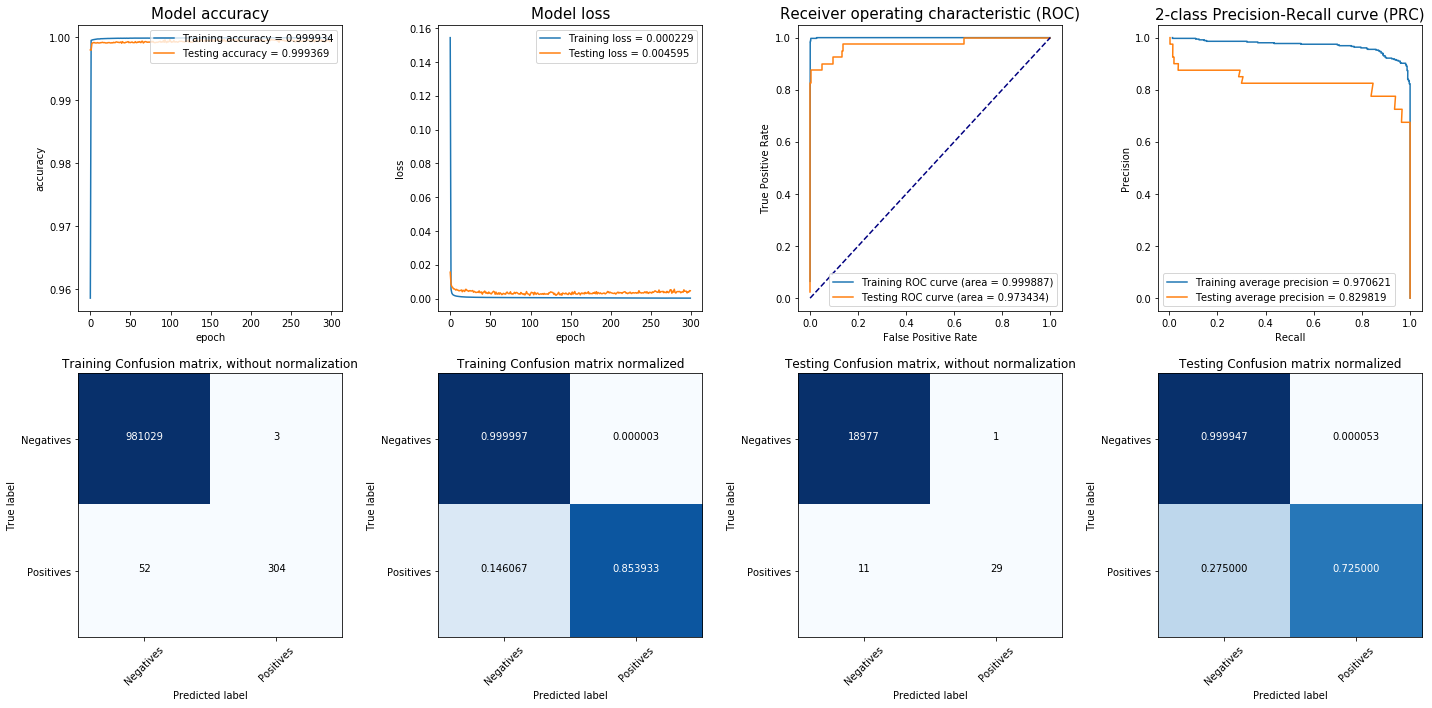

In [21]:
model.save("models/model")
model.save_weights("models/weights")

plot_summary_statistics(model, history, normalized_training,
                        normalized_testing, training_labels,
                        testing_labels)

### Making predictions

In [22]:
training_prediction = model.predict_proba(normalized_training)
testing_prediction = model.predict_proba(normalized_testing)

### Plotting loss and accuracy

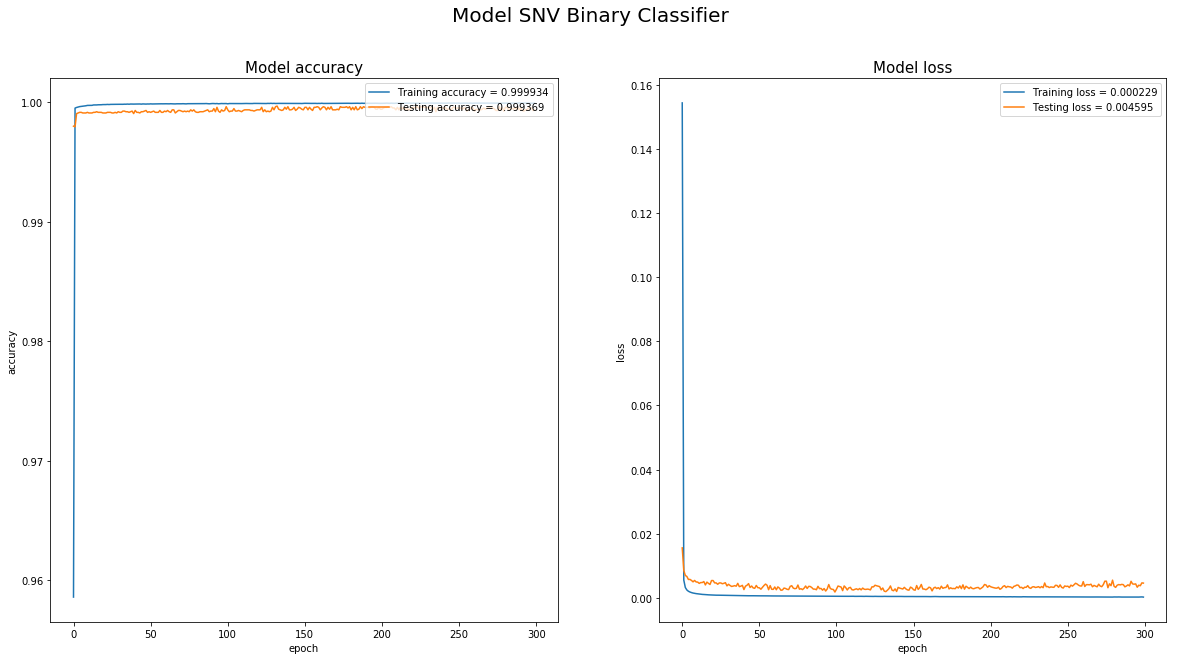

In [23]:
plt.figure(figsize=(20,10))
plt.suptitle("Model SNV Binary Classifier", fontsize=20)
plt.subplot(1, 2, 1)
plot_history_graph(history, 'acc', 'accuracy')
plt.subplot(1, 2, 2)
plot_history_graph(history, 'loss', 'loss')
plt.show()

### Plotting ROC and PRC

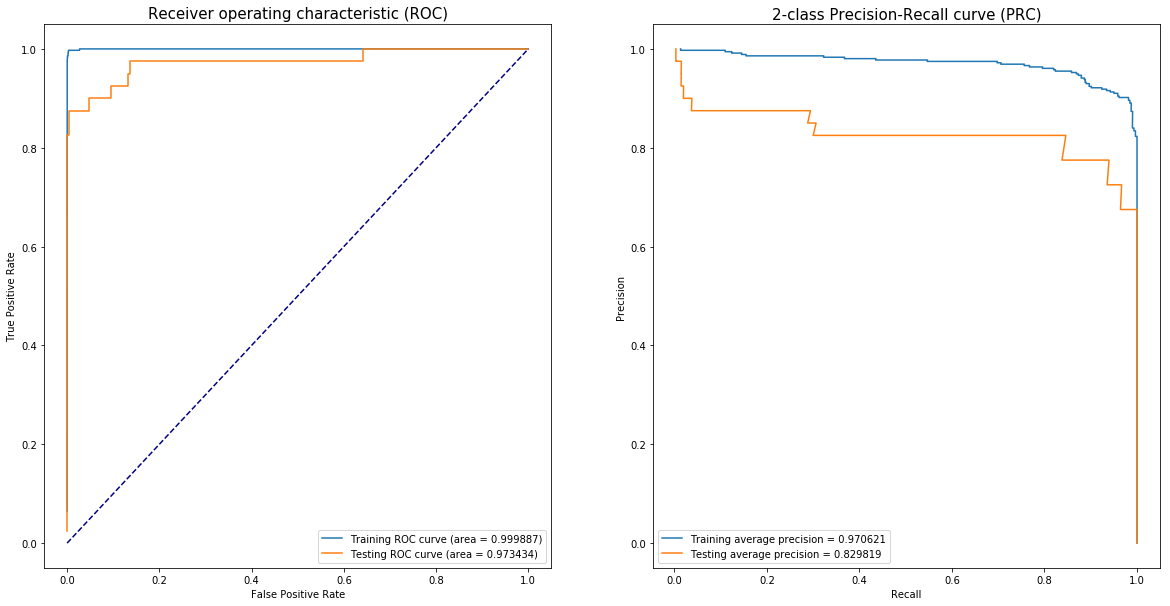

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plot_model_roc(training_labels, training_prediction, testing_labels,
               testing_prediction)
plt.subplot(1, 2, 2)
plot_model_prc(training_labels, training_prediction, testing_labels,
               testing_prediction)
plt.show()

### Confusion matrix for training set

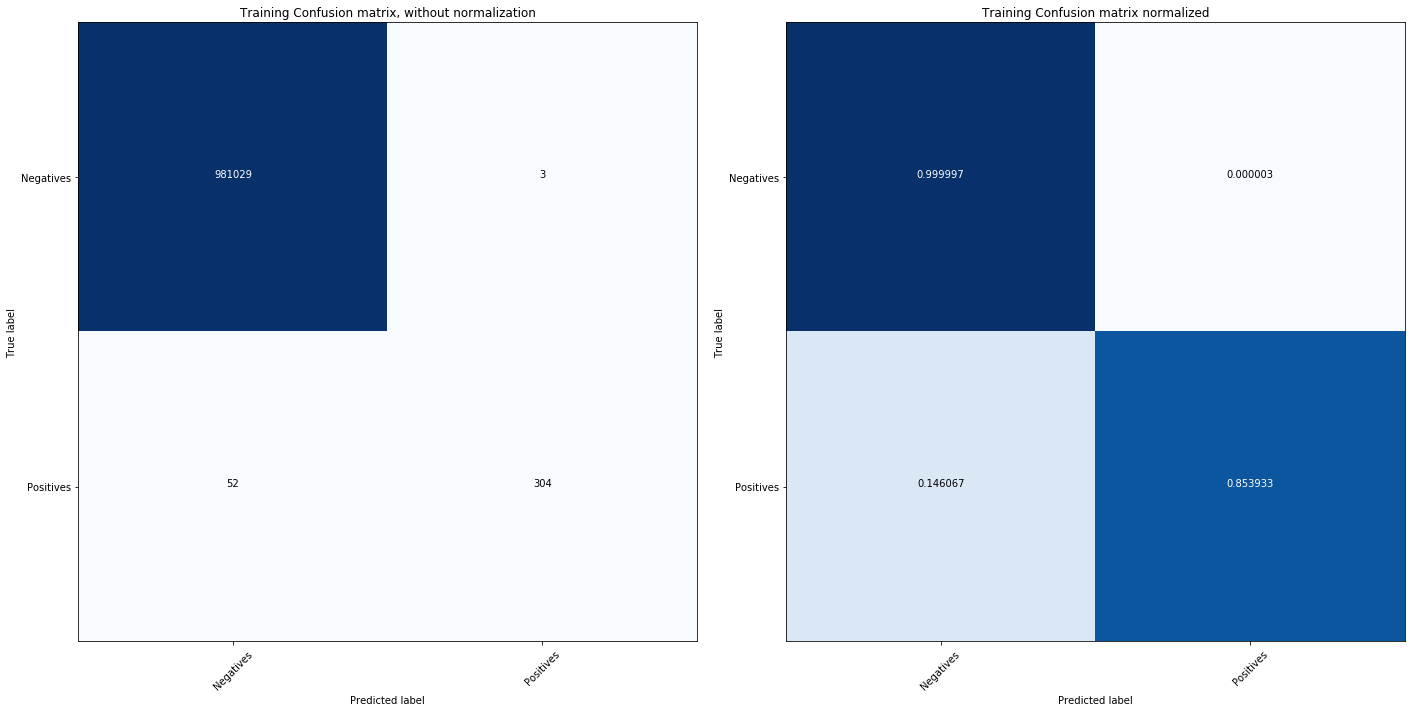

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(training_labels, training_prediction.round())

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"],
                      title='Training Confusion matrix, without normalization')
plt.subplot(1,2,2)
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"], normalize=True,
                      title='Training Confusion matrix normalized')
plt.show()

### Confusion matrix for testing set

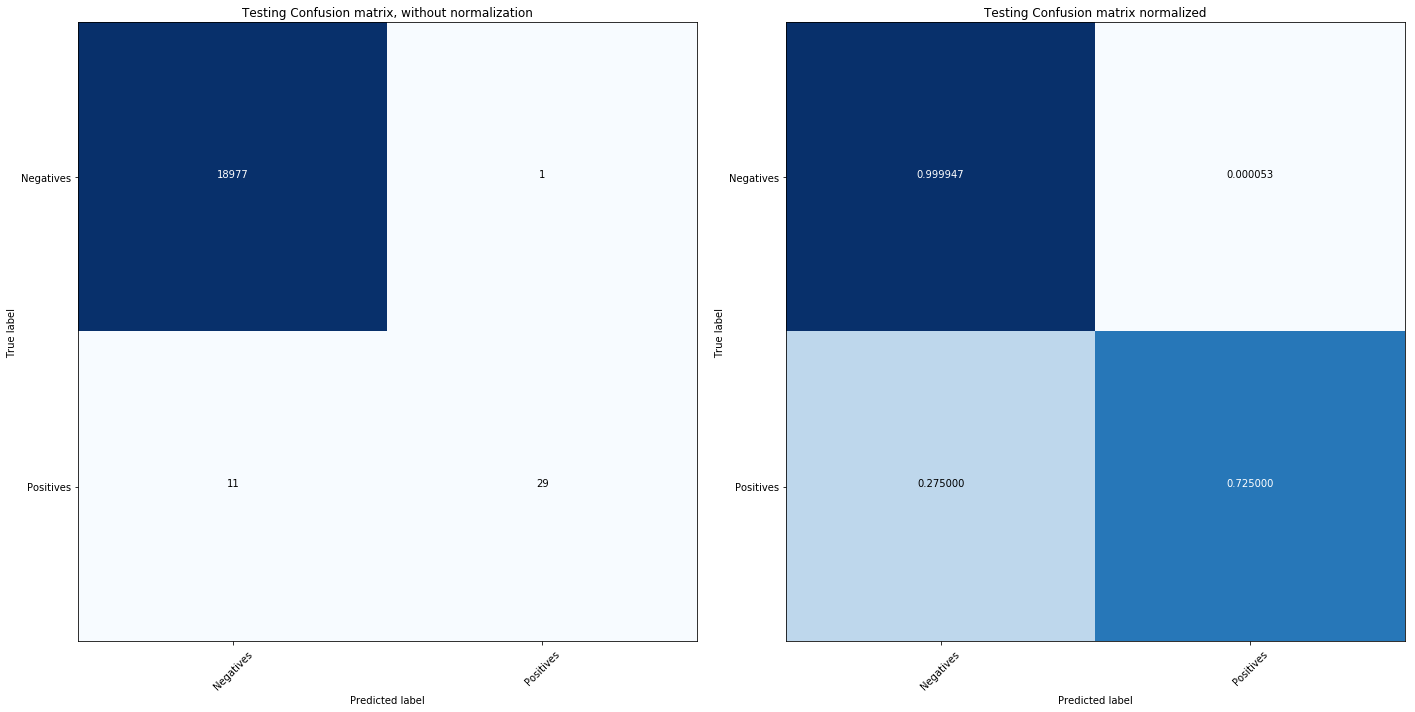

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(testing_labels, testing_prediction.round())

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"],
                      title='Testing Confusion matrix, without normalization')
plt.subplot(1,2,2)
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"], normalize=True,
                      title='Testing Confusion matrix normalized')
plt.show()